## Imports

In [1]:
from IPython.display import display

In [294]:
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

In [298]:
import torch
from torch.utils.tensorboard import SummaryWriter

In [295]:
from skorch import NeuralNetRegressor
from skorch.callbacks import WandbLogger, TensorBoard, Checkpoint, EarlyStopping

In [20]:
import rtdl

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# change the defaults
sns.set()

In [290]:
import tensorwatch as tw

## Read data and visualization

In [219]:
train_data = pd.read_csv("input/tabular-playground-series-jan2022/train.csv")
test_data = pd.read_csv("input/tabular-playground-series-jan2022/test.csv")

In [220]:
train_data.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


,row_id,date,country,store,product,num_sold
15,15,2015-01-01,Sweden,KaggleRama,Kaggle Mug,706
33,33,2015-01-02,Sweden,KaggleRama,Kaggle Mug,653
51,51,2015-01-03,Sweden,KaggleRama,Kaggle Mug,734
69,69,2015-01-04,Sweden,KaggleRama,Kaggle Mug,657
87,87,2015-01-05,Sweden,KaggleRama,Kaggle Mug,512
105,105,2015-01-06,Sweden,KaggleRama,Kaggle Mug,471
123,123,2015-01-07,Sweden,KaggleRama,Kaggle Mug,442
141,141,2015-01-08,Sweden,KaggleRama,Kaggle Mug,493
159,159,2015-01-09,Sweden,KaggleRama,Kaggle Mug,479
177,177,2015-01-10,Sweden,KaggleRama,Kaggle Mug,536


<AxesSubplot:title={'center':'Sales for Kaggle Mug from KaggleRama, Sweden.'}, xlabel='date', ylabel='num_sold'>

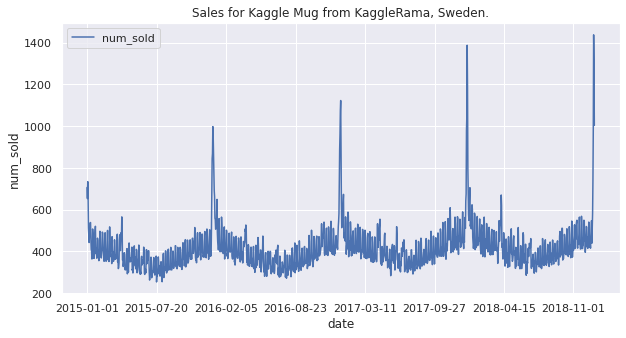

In [232]:
store_name = "KaggleRama"
country_name = "Sweden"
product_name = "Kaggle Mug"

train_data_subselect = train_data[
    (train_data['store'] == store_name) & (train_data['country'] == country_name) & (train_data['product'] == product_name)]
display(train_data_subselect.head(10))
train_data_subselect.plot(x='date', y='num_sold', ylabel='num_sold', figsize=(10, 5), title=f"Sales for {product_name} from {store_name}, {country_name}.")

## Agenda

- Create X_train (feature vectors) and y_train

- Create the timesplit K-folds, let us start with K=4

- Wrap the regression model with skorch regressor class

- Train the model and tune the hyper params easily

- Method to predict the whole 1 year on test data after training

### Create X_train and y_train

Feature vectors are the previous 7 days of sales, their diffs, average of 7 days, std of 7 days

In [169]:
def create_features(train_data):
    store_names = train_data.store.unique()
    country_names = train_data.country.unique()
    product_names = train_data['product'].unique()
    N = 7
    cat_features = ['store', 'country', 'product']
    features_list = []
    for store_name in store_names:
        for country_name in country_names:
            for product_name in product_names:
                train_data_subselect = train_data[
                            (train_data['store'] == store_name) & 
                            (train_data['country'] == country_name) & 
                            (train_data['product'] == product_name)]
                features = create_features_timeseries(train_data_subselect['num_sold'], N=7)
                features.loc[:, 'num_sold'] = np.asarray(train_data_subselect['num_sold'])[N:]
                features.loc[:, 'store'] = store_name
                features.loc[:, 'country'] = country_name
                features.loc[:, 'product'] = product_name
                features_list.append(features)
    return pd.concat(features_list, axis=0)

In [120]:
def create_features_timeseries(train_data_sold, N=7, feature_prefix='num_sold'):
    sales_prev = np.vstack([train_data_sold[k:-N+k] for k in range(N)]).T
    sales_prev_names = [f'{feature_prefix}_p{N-k}' for k in range(N)]
    sales_mean = np.mean(sales_prev, axis=1)
    sales_mean_names = [f'{feature_prefix}_{N}_mean']
    sales_diff = np.diff(sales_prev, axis=-1)
    sales_diff_names = [f'{feature_prefix}_d{N-k-1}' for k in range(N-1)]
    features = np.concatenate((sales_prev, sales_diff, sales_mean[:, np.newaxis]), axis=1)
    features = pd.DataFrame(features, columns=sales_prev_names + sales_diff_names + sales_mean_names)
    return features

In [317]:
# Extract the features and labels from train_data
train_features_labels = create_features(train_data)
train_labels = train_features_labels["num_sold"]
train_features = train_features_labels.drop("num_sold", axis=1)

In [247]:
ct_onehot = make_column_transformer(
    (OneHotEncoder(), ['country', 'store', 'product']),
    remainder='passthrough'
)

In [266]:
d_in = 22 # Is there a way to avoid hard coding this?
d_layers = [100, 100]
dropout = 0.1
d_out = 1

In [318]:
train_features_trans = ct_onehot.fit_transform(train_features).astype(np.float32)
train_labels = train_labels.astype(np.float32).to_numpy().reshape(-1, 1)

In [302]:
# Create tensorboard writer
writer = SummaryWriter()

mlp_2layer_callbacks = []
mlp_2layer_callbacks.append(EarlyStopping())
mlp_2layer_callbacks.append(Checkpoint())
mlp_2layer_callbacks.append(TensorBoard(writer))

In [315]:
mlp_2layer_model = NeuralNetRegressor(
    module=rtdl.MLP.make_baseline,
    module__d_in=d_in,
    module__d_layers=d_layers,
    module__dropout=dropout,
    module__d_out=d_out,
    optimizer=torch.optim.Adam,
    # optimizer__lr=1e-4,
    callbacks=mlp_2layer_callbacks
)
mlp_2layer_model.initialize()
display(mlp_2layer_model)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP(
    (blocks): Sequential(
      (0): Block(
        (linear): Linear(in_features=22, out_features=100, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=100, out_features=100, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (head): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [272]:
# TODO: Get the pipeline working :)
mlp2layer_pipe = Pipeline([
    ('scale', ct_onehot),
    ('net', mlp_2layer_model),
])

In [280]:
mlp_2layer_model.predict(train_features_trans)

array([[36.386063],
       [33.151398],
       [30.609652],
       ...,
       [32.246727],
       [43.03192 ],
       [57.972626]], dtype=float32)

In [316]:
mlp_2layer_model.fit(train_features_trans, train_labels, epochs=50)

Re-initializing module because the following parameters were re-set: d_in, d_layers, d_out, dropout.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1     7260.7432     1771.3593     +  0.5025
      2    11264.4827     1351.0645     +  0.4702
      3     5782.5313      960.2294     +  0.4713
      4     5257.4364      964.3528        0.4556
      5     5525.8529     1180.4815        0.4365
      6     6568.6422      962.2686        0.4640
      7     5099.5429      995.3724        0.5074
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP(
    (blocks): Sequential(
      (0): Block(
        (linear): Linear(in_features=22, out_features=100, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=100, out_features=100, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (head): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [233]:
def regression_results(y_true, y_pred):
    
    results = {}
    results['explained_variance'] = metrics.explained_variance_score(y_true, y_pred)
    results['mae'] = metrics.mean_absolute_error(y_true, y_pred) 
    results['mse'] = metrics.mean_squared_error(y_true, y_pred) 
    results['msle'] = metrics.mean_squared_log_error(y_true, y_pred)
    results['median_ae'] = metrics.median_absolute_error(y_true, y_pred)
    results['r2'] = metrics.r2_score(y_true, y_pred)
    results['rmse'] = np.sqrt(results['mse'])
    return pd.Series(results)

In [319]:
cross_val_score(
    mlp_2layer_model,
    
)

Signature:
cross_val_score(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    scoring=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    error_score=nan,
)
Docstring:
Evaluate a score by cross-validation

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
estimator : estimator object implementing 'fit'
    The object to use to fit the data.

X : array-like of shape (n_samples, n_features)
    The data to fit. Can be for example a list, or an array.

y : array-like of shape (n_samples,) or (n_samples, n_outputs),             default=None
    The target variable to try to predict in the case of
    supervised learning.

groups : array-like of shape (n_samples,), default=None
    Group labels for the samples used while splitting the dataset into
    train/test set. Only used in conjunction with a "Group" :term:`cv`
    instance (e.g., :class:`GroupKFold`).

scoring : str or callable, default=None
